# Classificação de Alimentos com CNN e Transfer Learning

Este notebook apresenta a implementação do modelo de **classificação de frutas, legumes e sementes** utilizando técnicas de **transfer learning** com a arquitetura **ResNet50**, previamente treinada na base **ImageNet**.

O notebook está organizado nas seguintes etapas principais:

1. Coleta e Processamento de Dados
   - Carregamento das imagens e mapeamento das classes de acordo com a correspondência dos alimentos da Tabela INSA.  
   - Redimensionamento das imagens para 224x224 pixels e normalização.  
   - Divisão do conjunto de dados em treino, validação e teste.

2. Treinamento do Modelo
  - ResNet50 sem a camada de saída original, camadas convolucionais congeladas e adição de head personalizada com Global Average Pooling, Dropout (30%) e camada Dense com Softmax.  
  - Compilação com Adam e categorical_crossentropy, uso de callbacks (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau e HistorySaver).

3. Avaliação
  - Métricas de validação mostram desempenho excelente, com acurácia geral próxima de 100% e F1-score médio ~1.0. Algumas classes apresentam pequenas quedas, indicando sobreposição visual com outras categorias.


## Coleta de Dados
- Nesta seção, os dados do dataset fruits-360, são filtrados de acordo com os alimentos selecionados da tabela INSA.

In [ ]:
&from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Testar o TensorFlow e PyTorch
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
print("TensorFlow:", tf.__version__)
print("PyTorch:", torch.__version__)

TensorFlow: 2.18.0
PyTorch: 2.6.0+cu124


In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# # Explode as strings da coluna em subcategorias individuais
# classes_base_raw = df_insa['Categorias do modelo'].dropna().tolist()

# # Quebra por vírgula, limpa espaços e padroniza lowercase
# classes_base_flat = []
# for grupo in classes_base_raw:
#     subcategorias = grupo.split(',')
#     for sub in subcategorias:
#         classes_base_flat.append(sub.strip().lower())

# # Transforma em conjunto para eliminar duplicatas
# classes_base_final = set(classes_base_flat)

# print(f"Total de classes únicas esperadas: {len(classes_base_final)}")  # deve ser 183


In [ ]:
# # Clonar o repositório
# !git clone https://github.com/fruits-360/fruits-360-100x100.git

# # Verificar conteúdo
# !ls fruits-360-100x100

Cloning into 'fruits-360-100x100'...
remote: Enumerating objects: 140541, done.
remote: Counting objects: 100% (6401/6401), done.
remote: Compressing objects: 100% (6378/6378), done.
^C
ls: cannot access 'fruits-360-100x100': No such file or directory


In [ ]:
# import shutil
# import os

# # Caminhos
# base_origem = '/content/fruits-360-100x100'
# pastas = ['Training', 'Test']
# base_destino = '/content/fruits360_filtered'

# classes_encontradas = set()
# classes_faltando = set()

# for pasta in pastas:
#     origem = os.path.join(base_origem, pasta)
#     destino = os.path.join(base_destino, pasta)
#     os.makedirs(destino, exist_ok=True)

#     for classe in os.listdir(origem):
#         classe_normalizada = classe.lower().strip().replace('_', ' ')
#         if classe_normalizada in classes_base_final:
#             origem_classe = os.path.join(origem, classe)
#             destino_classe = os.path.join(destino, classe)
#             shutil.copytree(origem_classe, destino_classe, dirs_exist_ok=True)
#             classes_encontradas.add(classe_normalizada)

# # Verificação final
# faltando = classes_base_final - classes_encontradas

# print(f"Total esperado: {len(classes_base_final)}")
# print(f"Total encontrado: {len(classes_encontradas)}")
# print(f"Total faltando: {len(faltando)}")
# print("Classes faltando:")
# print(sorted(faltando))


In [ ]:
# import zipfile

# # 1. Caminho para salvar CSV temporário
# csv_path = '/content/df_insa.csv'

# # 2. Salvar o DataFrame em CSV
# df_insa.to_csv(csv_path, index=False)

# # 3. Compactar em ZIP
# zip_path = '/content/df_insa.zip'
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(csv_path, arcname='df_insa.csv')

# # 4. Copiar para o Google Drive
# !cp /content/df_insa.zip /content/drive/MyDrive/

## Processamento dos Dados
- Nesta seção, os dados filtrados são dividicos em treino, teste e validação.
- Também há o pré-processamento dos dados em preparação para o treinamento CNN com transfer learning.

In [ ]:
# import os
# import shutil
# import random

# origem_train = '/content/fruits360_filtered/Training'
# destino_train = '/content/fruits360_final/Training'
# destino_val = '/content/fruits360_final/Validation'

# os.makedirs(destino_train, exist_ok=True)
# os.makedirs(destino_val, exist_ok=True)

# val_ratio = 0.2  # 20% para validação

# for classe in os.listdir(origem_train):
#     caminho_classe = os.path.join(origem_train, classe)
#     imagens = os.listdir(caminho_classe)
#     random.shuffle(imagens)

#     num_val = int(len(imagens) * val_ratio)

#     # Criação das pastas de destino
#     os.makedirs(os.path.join(destino_train, classe), exist_ok=True)
#     os.makedirs(os.path.join(destino_val, classe), exist_ok=True)

#     for i, imagem in enumerate(imagens):
#         origem_img = os.path.join(caminho_classe, imagem)
#         if i < num_val:
#             destino_img = os.path.join(destino_val, classe, imagem)
#         else:
#             destino_img = os.path.join(destino_train, classe, imagem)
#         shutil.copy2(origem_img, destino_img)

# print("Divisão concluída.")

In [ ]:
# Em sessões futuras, apenas monte o Drive e descompacte:
!cp /content/drive/MyDrive/df_insa.zip /content/
!unzip -q /content/df_insa.zip

In [ ]:
# import pandas as pd
# df_insa = pd.read_excel('INSA_classescnn.xlsx', skiprows=[0])
# df_insa = df_insa.drop(['Cod'], axis=1)
# df_insa.head()

In [ ]:
# origem_test = '/content/fruits360_filtered/Test'
# destino_test = '/content/fruits360_final/Test'

# shutil.copytree(origem_test, destino_test, dirs_exist_ok=True)

# # Compacte o dataset já filtrado e dividido (treino/val/validação):
# !zip -r /content/fruits360_final.zip /content/fruits360_final

In [ ]:
# # Salve esse .zip no seu Drive uma única vez:
# !cp /content/fruits360_final.zip /content/drive/MyDrive/

In [ ]:
# Para seções futuras, montar o Drive e descompactar:
!cp /content/drive/MyDrive/fruits360_final.zip /content/
!unzip -q /content/fruits360_final.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os

base_dir = '/content/content/fruits360_final/'  # onde estão as pastas Training, Validation, Test

train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')


batch_size = 32
img_size = (224, 224)  # tamanho padrão para modelos como ResNet50

train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 75555 images belonging to 185 classes.
Found 18814 images belonging to 185 classes.
Found 31503 images belonging to 185 classes.


In [ ]:
# train_generator = train_datagen.flow_from_directory(
#     train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
# )
# val_generator = val_datagen.flow_from_directory(
#     val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
# )
# test_generator = test_datagen.flow_from_directory(
#     test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
# )


## Treinamento

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelar os pesos

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Caminho onde o melhor modelo será salvo
checkpoint_path = '/content/drive/MyDrive/modelos/melhor_modelo.keras'
# Callback para salvar o melhor modelo com base em val_loss
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Callback para parar o treinamento se não houver melhora
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Para após 5 épocas sem melhora
    verbose=1,
    restore_best_weights=True
)

# Callback para reduzir a learning rate se a validação parar de melhorar
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

from tensorflow.keras.callbacks import Callback
import pickle

class HistorySaver(Callback):
    def __init__(self, path='/content/drive/MyDrive/modelos/history.pkl'):
        super().__init__()
        self.path = path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        # Salva a cada época
        with open(self.path, 'wb') as f:
            pickle.dump(self.history, f)

history_saver = HistorySaver('/content/drive/MyDrive/modelos/history.pkl')


In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=30,
#     callbacks=[checkpoint, early_stop, reduce_lr, history_saver]
# )

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/modelos/melhor_modelo.keras')


In [ ]:
import pickle

with open('/content/drive/MyDrive/modelos/history.pkl', 'rb') as f:
    saved_history = pickle.load(f)

# Verifique quantas épocas já foram concluídas
print(f"Épocas concluídas: {len(saved_history['loss'])}")


Épocas concluídas: 4


In [ ]:
# Continuação do treinamento por mais 3 épocas
history_continue = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # ainda vai parar em 30
    initial_epoch=len(saved_history['loss']),  # começa da 27
    callbacks=[checkpoint, early_stop, reduce_lr, history_saver]
)

Epoch 5/30
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9991 - loss: 0.0037
Epoch 5: val_loss improved from 0.00171 to 0.00160, saving model to /content/drive/MyDrive/modelos/melhor_modelo.keras
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 961s 402ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 6/30
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9995 - loss: 0.0029
Epoch 6: val_loss improved from 0.00160 to 0.00146, saving model to /content/drive/MyDrive/modelos/melhor_modelo.keras
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 946s 400ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9999 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 7/30
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9995 - loss: 0.0028
Epoch 7: val_loss did not improve from 0.00146
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 942s 399ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9999 - val_loss: 0.0015 - learning_rate: 1.0

In [ ]:
for key in history_continue.history:
    saved_history[key].extend(history_continue.history[key])

# Salvar histórico completo novamente
with open('/content/drive/MyDrive/modelos/history.pkl', 'wb') as f:
    pickle.dump(saved_history, f)

In [ ]:
import pickle

# Salvar os índices de classes
with open('/content/drive/MyDrive/modelos/class_indices.pkl', 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

## Avaliação do Modelo

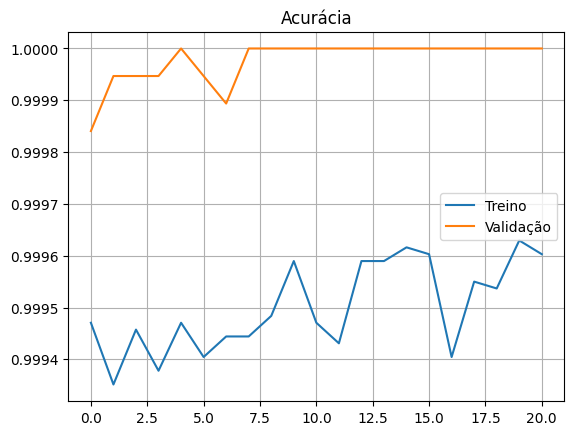

In [ ]:
# Carregar
with open('/content/drive/MyDrive/modelos/history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Plotar
plt.plot(history_data['accuracy'], label='Treino')
plt.plot(history_data['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")


985/985 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.9964 - loss: 0.0180
Acurácia no conjunto de teste: 0.9963


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verdadeiros
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Relatório
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


985/985 ━━━━━━━━━━━━━━━━━━━━ 90s 88ms/step
                           precision    recall  f1-score   support

                 Apple 10       1.00      1.00      1.00       231
                 Apple 11       1.00      1.00      1.00       142
                 Apple 12       1.00      1.00      1.00       154
                 Apple 13       1.00      1.00      1.00       235
                 Apple 14       1.00      1.00      1.00       154
                 Apple 17       1.00      1.00      1.00       201
                 Apple 18       1.00      1.00      1.00       160
                 Apple 19       1.00      1.00      1.00       241
                  Apple 5       1.00      1.00      1.00       146
                  Apple 6       0.98      1.00      0.99       157
                  Apple 7       1.00      1.00      1.00       229
                  Apple 8       1.00      1.00      1.00       228
                  Apple 9       1.00      1.00      1.00       231
         Apple Bra

Análise Geral:
Acurácia geral: ~100%

F1-Score médio: ~1.00 (praticamente perfeito)

Classes com desempenho um pouco abaixo:

Apple Red 2 – recall de 0.85

Corn Husk 1 – recall de 0.78

Beetroot 1, Eggplant 1, Tomato Heart 1 – F1 em torno de 0.92–0.96

Essas quedas são pequenas, mas podem indicar alguma sobreposição visual entre essas classes e outras semelhantes.
O que esses números dizem:
Seu modelo está generalizando muito bem.

Praticamente sem overfitting aparente (a menos que o conjunto de teste tenha alguma sobreposição com o de treino).

Você tem um sistema de classificação altamente confiável, que pode ser usado em produção com confiança.

# Detalhes do modelo

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,724,909 (94.32 MB)

 Trainable params: 379,065 (1.45 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 758,132 (2.89 MB)

In [ ]:
# Base da rede (ResNet)
base_layers = model.layers[:175]
# Head customizada
head_layers = model.layers[175:]

print("Base pré-treinada (ResNet-like):")
print(f" - Camadas: {len(base_layers)}")
print(f" - Tipo final: {base_layers[-1].__class__.__name__}")

print("Head personalizada:")
for layer in head_layers:
    config = layer.get_config()
    units = config.get("units", "")
    print(f" - {layer.name}: {layer.__class__.__name__} ({units})")


📦 Base pré-treinada (ResNet-like):
 - Camadas: 175
 - Tipo final: Activation

🔧 Head personalizada:
 - global_average_pooling2d_1: GlobalAveragePooling2D ()
 - dropout_1: Dropout ()
 - dense_1: Dense (185)


In [ ]:
print(model.optimizer.get_config())
print(model.loss)
print(model.metrics)


{'name': 'adam', 'learning_rate': 9.999999974752427e-07, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
categorical_crossentropy
[<Mean name=loss>, <CompileMetrics name=compile_metrics>]


In [ ]:
for layer in model.layers:
    print(layer.name, layer.get_weights())


A saída de streaming foi truncada nas últimas 5000 linhas.
       0.8146507 ], dtype=float32), array([-0.32308578, -0.46322548,  0.19813333, -1.342232  , -0.72588885,
       -1.5240322 , -0.24141543, -0.43097314, -0.9335884 , -0.7256827 ,
       -0.3168482 , -0.56163406, -0.81291395, -1.3516918 , -0.8271121 ,
       -1.1134933 , -0.1260493 , -0.409415  , -1.0258279 , -0.8124174 ,
       -0.14322503, -0.829899  , -1.0830342 , -0.8156975 , -0.911043  ,
       -0.99727994, -1.443129  , -1.215063  , -0.55268127,  0.33550555,
       -0.7825737 , -0.82935214,  0.11499776,  0.08230597, -0.10132784,
       -1.3044672 , -0.1347159 , -1.2974868 , -0.27327016, -0.5411258 ,
       -0.5272271 ,  0.43344903, -0.8676468 , -0.4719788 , -2.3216355 ,
       -0.42025113, -1.2384423 , -0.62394387, -0.644665  , -1.0948302 ,
       -0.858416  , -0.820064  , -0.30390188, -0.99727774, -1.1555109 ,
       -0.77533674, -1.0827688 , -0.7630514 , -0.95134974, -0.3988382 ,
       -1.0423687 , -0.6679081 , -0.80453

In [ ]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")


0: input_layer_1 (InputLayer)
1: conv1_pad (ZeroPadding2D)
2: conv1_conv (Conv2D)
3: conv1_bn (BatchNormalization)
4: conv1_relu (Activation)
5: pool1_pad (ZeroPadding2D)
6: pool1_pool (MaxPooling2D)
7: conv2_block1_1_conv (Conv2D)
8: conv2_block1_1_bn (BatchNormalization)
9: conv2_block1_1_relu (Activation)
10: conv2_block1_2_conv (Conv2D)
11: conv2_block1_2_bn (BatchNormalization)
12: conv2_block1_2_relu (Activation)
13: conv2_block1_0_conv (Conv2D)
14: conv2_block1_3_conv (Conv2D)
15: conv2_block1_0_bn (BatchNormalization)
16: conv2_block1_3_bn (BatchNormalization)
17: conv2_block1_add (Add)
18: conv2_block1_out (Activation)
19: conv2_block2_1_conv (Conv2D)
20: conv2_block2_1_bn (BatchNormalization)
21: conv2_block2_1_relu (Activation)
22: conv2_block2_2_conv (Conv2D)
23: conv2_block2_2_bn (BatchNormalization)
24: conv2_block2_2_relu (Activation)
25: conv2_block2_3_conv (Conv2D)
26: conv2_block2_3_bn (BatchNormalization)
27: conv2_block2_add (Add)
28: conv2_block2_out (Activation)
2